In [1]:
# Cell 1
import os, json, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tqdm import tqdm

RUNS = [
    {"dir": "KTH_results/both64_500_64_ctx64x64_fov32x32",
     "label": "KTH(64,32)",
     "color": "c",
     "model_arch": "64",
     "use_context": True,
     "use_fovea": True,
     "context_shape": (64,64,1),
     "fovea_shape": (32,32,1)},
    {"dir": "KTH_results/both32_500_64_ctx32x32_fov16x16",
     "label": "KTH(32,16)",
     "color": "orange",
     "model_arch": "32",
     "use_context": True,
     "use_fovea": True,
     "context_shape": (32,32,1),
     "fovea_shape": (16,16,1)},
]
FOLD = 1
OUT_PNG = "roc_fold.png"

2025-08-14 13:26:26.283312: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-14 13:26:26.283344: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-14 13:26:26.284498: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-14 13:26:26.293694: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-14 13:26:28.268920: W tensorflow/compiler/tf2

In [2]:
# Cell 2
def sizes_for_arch(arch):
    if arch == "64": return 16,16,10,16
    if arch == "32": return 16,32,20,32
    return 8,16,8,8

def build_branch(input_shape, c1, c2, prefix):
    i = keras.Input(shape=input_shape, name=f"{prefix}input")
    x = layers.Conv2D(c1, (3,3), kernel_initializer="he_normal", bias_initializer="zeros")(i)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(c2, (3,3), kernel_initializer="he_normal", bias_initializer="zeros")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    return i, x

def build_model(use_context, use_fovea, ctx_shape, fov_shape, num_classes, arch):
    c1,c2,d1,d2 = sizes_for_arch(arch)
    inputs, outs = [], []
    if use_context:
        ic, oc = build_branch(ctx_shape, c1, c2, "context_"); inputs.append(ic); outs.append(oc)
    if use_fovea:
        ifs, ofs = build_branch(fov_shape, c1, c2, "fovea_"); inputs.append(ifs); outs.append(ofs)
    z = outs[0] if len(outs)==1 else layers.Concatenate()(outs)
    z = layers.Dense(d1, kernel_initializer="he_normal", bias_initializer="zeros")(z)
    z = layers.Dropout(0.5)(z)
    z = layers.Dense(d2, kernel_initializer="he_normal", bias_initializer="zeros")(z)
    z = layers.Dropout(0.5)(z)
    o = layers.Dense(num_classes, activation="softmax", kernel_initializer="he_normal", bias_initializer="zeros")(z)
    return Model(inputs=inputs, outputs=o)

def make_ds(npz, ctx_shape, fov_shape, use_context, use_fovea, batch=64):
    y = npz["y"].astype(np.int32)
    feats = {}
    if use_context:
        feats["context_input"] = npz["X_context_paths"].astype(str)
    if use_fovea:
        feats["fovea_input"] = npz["X_fovea_paths"].astype(str)
    ctx_h,ctx_w,_ = ctx_shape; fov_h,fov_w,_ = fov_shape
    def gen():
        for i in range(len(y)):
            out = {}
            if use_context:
                img = tf.io.read_file(feats["context_input"][i])
                img = tf.io.decode_png(img, channels=1)
                img = tf.image.convert_image_dtype(img, tf.float32)
                img = tf.image.resize(img, [ctx_h, ctx_w])
                out["context_input"] = img
            if use_fovea:
                img = tf.io.read_file(feats["fovea_input"][i])
                img = tf.io.decode_png(img, channels=1)
                img = tf.image.convert_image_dtype(img, tf.float32)
                img = tf.image.resize(img, [fov_h, fov_w])
                out["fovea_input"] = img
            yield out, y[i]
    sig = {}
    if use_context: sig["context_input"] = tf.TensorSpec(ctx_shape, tf.float32)
    if use_fovea:   sig["fovea_input"]   = tf.TensorSpec(fov_shape, tf.float32)
    ds = tf.data.Dataset.from_generator(gen, output_signature=(sig, tf.TensorSpec([], tf.int32)))
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds, y


In [3]:
# Cell 3
def load_test_arrays(run, fold):
    npz_path = os.path.join(run["dir"], "test_data", f"fold_{fold}_test_data.npz")
    npz = np.load(npz_path, allow_pickle=True)
    y = npz["y"].astype(np.int32)
    X_ctx = None
    X_fov = None
    if run["use_context"]:
        ctx_h, ctx_w, _ = run["context_shape"]
        X_ctx = np.stack([
            tf.image.resize(
                tf.image.convert_image_dtype(
                    tf.io.decode_png(tf.io.read_file(p), channels=1), tf.float32
                ),
                [ctx_h, ctx_w]
            ).numpy()
            for p in npz["X_context_paths"].astype(str)
        ])
    if run["use_fovea"]:
        fov_h, fov_w, _ = run["fovea_shape"]
        X_fov = np.stack([
            tf.image.resize(
                tf.image.convert_image_dtype(
                    tf.io.decode_png(tf.io.read_file(p), channels=1), tf.float32
                ),
                [fov_h, fov_w]
            ).numpy()
            for p in npz["X_fovea_paths"].astype(str)
        ])
    return (X_ctx, X_fov, y)

def roc_for_run_fast(run, fold, X_ctx, X_fov, y_true):
    num_classes = len(np.unique(y_true))
    model = build_model(run["use_context"], run["use_fovea"], run["context_shape"], run["fovea_shape"], num_classes, run["model_arch"])
    ckpt = os.path.join(run["dir"], "checkpoints", f"fold_{fold}_best_model.keras")
    model.load_weights(ckpt)
    if run["use_context"] and run["use_fovea"]:
        y_score = model.predict([X_ctx, X_fov], verbose=0)
    elif run["use_context"]:
        y_score = model.predict(X_ctx, verbose=0)
    else:
        y_score = model.predict(X_fov, verbose=0)
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    return fpr, tpr, auc(fpr, tpr)

print("Loading test data once...")
X_ctx_list, X_fov_list, y_true_list = [], [], []
for run in tqdm(RUNS):
    X_ctx, X_fov, y_true = load_test_arrays(run, FOLD)
    X_ctx_list.append(X_ctx)
    X_fov_list.append(X_fov)
    y_true_list.append(y_true)

roc_data = []
for run, X_ctx, X_fov, y_true in tqdm(zip(RUNS, X_ctx_list, X_fov_list, y_true_list), total=len(RUNS), desc="run roc"):
    roc_data.append(roc_for_run_fast(run, FOLD, X_ctx, X_fov, y_true))


Loading test data once...


  0%|          | 0/2 [00:00<?, ?it/s]2025-08-14 13:26:30.162658: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-14 13:26:30.213334: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-14 13:26:30.215278: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Document

/tmp/ipykernel_9929/710148381.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


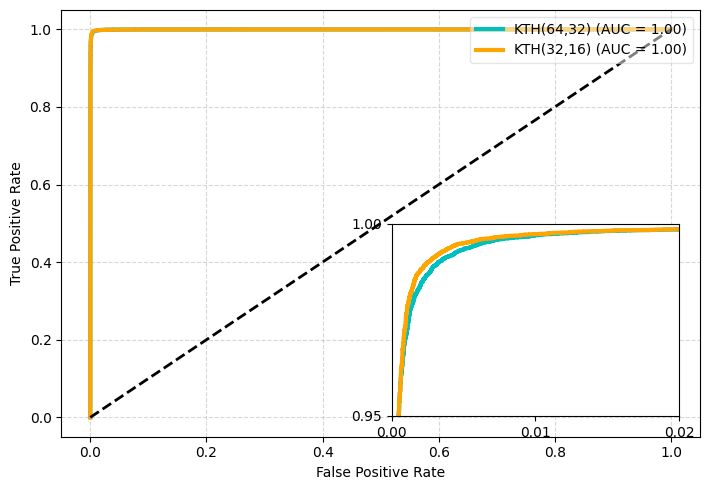

In [9]:
# Cell 4
plt.figure(figsize=(7.2,5))
for (fpr,tpr,aucv), run in zip(roc_data, RUNS):
    plt.plot(fpr, tpr, label=f"{run['label']} (AUC = {aucv:.2f})", color=run["color"], linewidth=3)
plt.plot([0,1],[0,1],"k--", linewidth=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True, linestyle="--", alpha=0.5)

plt.legend(loc="upper right", framealpha=0.5)

axins = inset_axes(plt.gca(), width="45%", height="45%", loc="lower right", borderpad=1.5)
for (fpr,tpr,aucv), run in zip(roc_data, RUNS):
    axins.plot(fpr, tpr, color=run["color"], linewidth=3)
axins.set_xlim(0.0, 0.02)
axins.set_ylim(0.95, 1.0)
axins.set_xticks([0.00,0.01,0.02])
axins.set_yticks([0.95,1.0])

plt.tight_layout()
plt.savefig(OUT_PNG, dpi=300, bbox_inches="tight")
plt.show()

